In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [146]:
g=1
H_ = 1
Nx=51
Ny=51
Nt=10000
dt = 0.001
h = np.zeros((51,51))
u = np.zeros((51,51))
v = np.zeros((51,51))
for i in range(51):
    for j in range(51):
        h[i][j] = (25 - np.abs(25-i)+25 - np.abs(25-j))

In [152]:
def periodic_derive_x(h,delta,Nx,Ny):
    hx=np.zeros((Nx,Ny))
    hx[0,:] = (h[1,:] - h[-1,:]) / (2 * delta)
    hx[1:(Nx-1),:] = (h[2:Nx,:] - h[0:(Nx-2),:]) / (2 * delta)
    hx[Nx-1,:] = (h[0,:] - h[Nx-2,:]) / (2 * delta)
    
    return hx

def periodic_derive_y(h,delta,Nx,Ny):
    hy=np.zeros((Nx,Ny))
    hy[:,0] = (h[:,1] - h[:,-1]) / (2 * delta)
    hy[:,1:(Ny-1)]= (h[:,2:Ny] - h[:,0:(Ny-2)]) / (2 * delta)
    hy[:,Ny-1] = (h[:,0] - h[:,Ny-2]) / (2 * delta)
    
    return hy

def stupid_scheme_step(u,v,h,Nx,Ny,dt,Nt,g=1,H_=1):
    dx = 1/Nx
    dy = 1/Ny
    u_new = u.copy()
    v_new = v.copy()
    h_new = h.copy()
    #производные через центральные разности 
    hx = periodic_derive_x(h,dx,Nx,Ny)
    hy = periodic_derive_y(h,dy,Nx,Ny)
    ux = periodic_derive_x(u,dx,Nx,Ny)
    vy = periodic_derive_y(v,dy,Nx,Ny)
    #новые значения
    u_new = u - g * dt * hx
    v_new = v - g * dt * hy
    h_new = h - H_ * dt * (ux + vy)
    return u_new,v_new,h_new

def stupid_scheme(u,v,h,Nx,Ny,dt,Nt,g=1,H_=1):
    h_new = []
    u1,v1,h1 = u.copy(),v.copy(),h.copy()
    h_new.append(h.copy())
    for i in range(Nt):
        u1,v1,h1 = stupid_scheme_step(u1,v1,h1,Nx,Ny,dt,Nt,g,H_)
        h_new.append(h1.copy())
    return h_new

In [153]:
H = stupid_scheme(u,v,h,Nx,Ny,dt,Nt,g,H_)

<IPython.core.display.Javascript object>


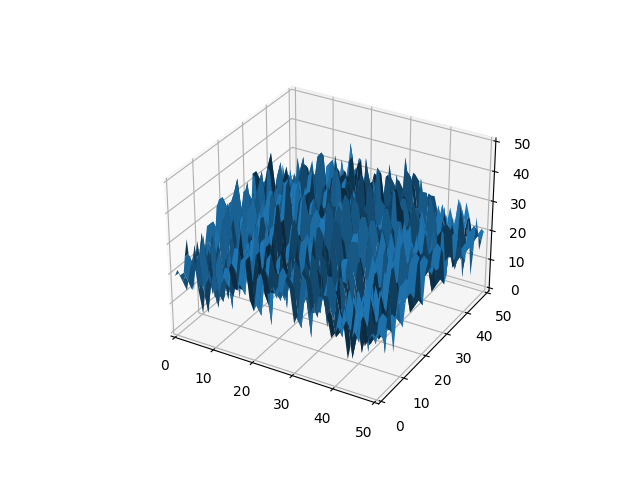

In [154]:
from mpl_toolkits.mplot3d import Axes3D
b = range(0,51,1)
d = range(0,51,1)
%matplotlib notebook
B, D = np.meshgrid(b, d)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim(0, 50)
ax.set_ylim(0, 50)
ax.set_zlim(np.min(H[0]), np.max(H[0]))
def animate2(i):
    ax.clear()
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 50)
    ax.set_zlim(0, np.max(H[0]))
    ax.plot_surface(B, D, H[10*i],vmin = np.min(H[0]), vmax = np.max(H[0]),norm=True)
ani = FuncAnimation(fig=fig, func=animate2, frames=1000, interval=1, repeat=True)
plt.show()

In [155]:
#fig = plt.figure(figsize=(6, 4))
#x = fig.add_subplot(111)
#_d, = ax.plot([], [], linewidth=2.5)
#ef animate1(i):
#   ax.imshow(H[2*i],vmin = np.min(H[0]), vmax = np.max(H[0]))
#ni = FuncAnimation(fig=fig, func=animate1, frames=200, interval=0.5, repeat=True)
#lt.show()